In [1]:
from torchvision.models import vit_b_32, ConvNeXt_Large_Weights
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
from Encoders import SwinSmall
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from utils import get_best_available_device
from dataset import ImageDataset
import matplotlib.pyplot as plt

# 1. Get dataset

In [2]:
BATCH_SIZE = 32
device = get_best_available_device()
print("Using device:", device)

dataset = ImageDataset(path="../../data/training/", device="cpu", use_patches=False)
dataloader = iter(DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True))

Using device: cpu


Loading images:   0%|          | 0/134 [00:00<?, ?it/s]

Loading images:   0%|          | 0/134 [00:00<?, ?it/s]

In [3]:
print(f"There are {len(dataloader)} images in the dataset.")

There are 26 images in the dataset.


Index: 29, mod: 5
Index: 419, mod: 5
Index: 236, mod: 2
Index: 732, mod: 0
Index: 467, mod: 5
Index: 337, mod: 1
Index: 334, mod: 4
Index: 764, mod: 2
Index: 588, mod: 0
Index: 455, mod: 5
Index: 477, mod: 3
Index: 167, mod: 5
Index: 760, mod: 4
Index: 779, mod: 5
Index: 471, mod: 3
Index: 617, mod: 5
Index: 795, mod: 3
Index: 574, mod: 4
Index: 73, mod: 1
Index: 208, mod: 4
Index: 196, mod: 4
Index: 490, mod: 4
Index: 414, mod: 0
Index: 608, mod: 2
Index: 496, mod: 4
Index: 7, mod: 1
Index: 315, mod: 3
Index: 657, mod: 3
Index: 43, mod: 1
Index: 777, mod: 3
Index: 699, mod: 3
Index: 24, mod: 0


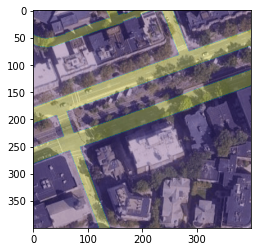

In [4]:
batch = next(dataloader)
images, masks = batch

plt.imshow(images[0].numpy().transpose(1, 2, 0))
plt.imshow(masks[0].numpy().transpose(1, 2, 0), alpha=0.3)
plt.show()

# 2. Create model and load weights

In [5]:
# weights = ConvNeXt_Small_Weights.IMAGENET1K_V1
# encoder = convnext_small(weights=weights).to("cpu")
encoder = SwinSmall.swin_pretrained().to("cpu")

In [6]:
import json

with open('imagenet_labels.json', 'r') as f:
    labels = json.load(f)["labels"]


In [7]:
# preprocess = weights.transforms()
# preprocess
# TODO do we remove preprocessing?

In [8]:
with torch.no_grad():
    out = encoder(images)  
# len(encoder.x_int)
sizes = [(y.shape[1], x.shape[1])  for x,y in zip(encoder.x_int, encoder.x_int[1:])]
sizes.reverse()
# for int in encoder.x_int:
    # print(int.shape)
# out.shape
print("those are the sizes for the decoder inferred from the encoder", sizes)


those are the sizes for the decoder inferred from the encoder [(768, 384), (384, 192), (192, 96), (96, 3)]


In [9]:
from Decoders.CustomDecoder import Decoder
decoder = Decoder(sizes=sizes)

In [10]:
class unet(torch.nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
        encoder_weights=None,
        decoder_weights=None,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.prev_conv = torch.nn.Conv2d(
            768, 768, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        # askip on preprocess les images
        x = self.encoder(x)
        x = self.prev_conv(x)
        for int in self.encoder.x_int:
            print(int.shape)
        x = self.decoder(x, self.encoder.x_int[::-1])
        return x



    

In [11]:
model_unet = unet(
    encoder=encoder,
    decoder=decoder).to(device)

In [12]:
with torch.no_grad():
    out2 = model_unet(images)

torch.Size([32, 3, 400, 400])
torch.Size([32, 96, 100, 100])
torch.Size([32, 192, 50, 50])
torch.Size([32, 384, 25, 25])
torch.Size([32, 768, 13, 13])
torch.Size([32, 768, 13, 13]) torch.Size([32, 768, 13, 13]) torch.Size([32, 384, 14, 14])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 14 but got size 13 for tensor number 1 in the list.